In [ ]:
# !pip install opendatasets --upgrade --quiet
!pip install statsmodels --upgrade --quiet

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam,SGD
import pandas as pd
import os
import opendatasets as od
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset'
# Using opendatasets let's download the data sets
od.download(dataset )

Skipping, found downloaded files in ".\bank-customer-churn-dataset" (use force=True to force download)


In [3]:
df = pd.read_csv("D:/DataAnalysis/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df = df.drop(['customer_id','country','gender'], axis=1)
df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   age               10000 non-null  int64  
 2   tenure            10000 non-null  int64  
 3   balance           10000 non-null  float64
 4   products_number   10000 non-null  int64  
 5   credit_card       10000 non-null  int64  
 6   active_member     10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   churn             10000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 703.2 KB


In [6]:
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
# performing chi square test on tenure products_number,credit_card,active_member, churn

#making contengancy table
list_cat = ["products_number","credit_card","active_member","tenure"]
for i in list_cat:
    dataCrosstab = pd.crosstab(df[i],df['churn'])
    chi2, p, dof, expected = chi2_contingency(dataCrosstab)
    if(p < 0.05):
        print(i+" and churn are dependent as p ="+ str(p))
    else:
        print(i+" and churn are independent  as p ="+str(p))
# as we can see   products_number and   active_member are dependent on churn so dropping credit_card and tenure

products_number and churn are dependent as p =0.0
credit_card and churn are independent  as p =0.49237236141554686
active_member and churn are dependent as p =8.785858269303703e-55
tenure and churn are independent  as p =0.17758462026413294


In [8]:
df = df.drop(['credit_card','tenure'], axis=1)
df.head()

,credit_score,age,balance,products_number,active_member,estimated_salary,churn
0,619,42,0.00,1,1,101348.88,1
1,608,41,83807.86,1,1,112542.58,0
2,502,42,159660.80,3,0,113931.57,1
3,699,39,0.00,2,0,93826.63,0
4,850,43,125510.82,1,1,79084.10,0


In [9]:
#performing anova test num vs cat cols for dependency check
num_cols = ["credit_score","age","balance","estimated_salary"]
for i in num_cols:
  # Performing two-way ANOVA
    model = ols(i+' ~ churn', data = df).fit()
    result = sm.stats.anova_lm(model, typ=2)
    if(result['PR(>F)']['churn'] < 0.05):
        print(i+" and churn are dependent as p ="+ str(result['PR(>F)']['churn']))
    else:
        print(i+" and churn are independent as p ="+ str(result['PR(>F)']['churn']))
# estimated_salary is not dependent on churn hence  dropping it

credit_score and churn are dependent as p =0.006738213892205324
age and churn are dependent as p =1.2399313093459443e-186
balance and churn are dependent as p =1.2755633191546494e-32
estimated_salary and churn are independent as p =0.22644042802263928


In [10]:
df = df.drop(['estimated_salary'], axis=1)
df.head()

,credit_score,age,balance,products_number,active_member,churn
0,619,42,0.00,1,1,1
1,608,41,83807.86,1,1,0
2,502,42,159660.80,3,0,1
3,699,39,0.00,2,0,0
4,850,43,125510.82,1,1,0


In [11]:
X = df[['credit_score','age','balance','products_number','active_member']]
y= df['churn']

In [12]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y ,  random_state=104,  test_size=0.25, shuffle=True)

In [13]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.7952

In [16]:
#Defining the X,w and y for tf malupulation
y = tf.constant(y_train,dtype=tf.float32)
y = tf.reshape(y, [y_train.shape[0],1])
x = tf.constant(tf.concat([X_train, tf.ones([X_train.shape[0], 1], tf.float32)], 1))
w = tf.Variable(tf.random.uniform(shape=[1,x.shape[1]], maxval=0, dtype=tf.float32, seed=431))
print(x.shape)
print(y.shape)
print(w.shape)

(7500, 6)
(7500, 1)
(1, 6)


In [17]:
alpha =0.01
opti= Adam(learning_rate=alpha)
# opti = SGD(learning_rate= alpha)
iter = 100
c=[]
for i in range(iter):
    with tf.GradientTape() as tape:
        yhat = tf.math.sigmoid(tf.matmul(w,tf.transpose(x))) 
        yhat = tf.clip_by_value(yhat, 1e-9, 1.)
        a = tf.multiply(tf.math.log(yhat),y)
        b = tf.multiply(tf.math.log(1-yhat),(1-y))
        loss =  -(a+b)
    c.append(tf.reduce_sum(loss/y.shape[0]))
    grad = tape.gradient(loss,[w])
    opti.apply_gradients(zip(grad,[w])) # adam optimizer

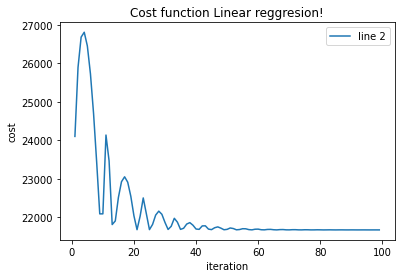

In [18]:
# plotting the cost function for LR confermation
l=np.arange(1,len(c))
plt.plot(l, c[1:], label = "line 2")

# naming the x axis
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('cost')
# giving a title to my graph
plt.title('Cost function Linear reggresion!')

# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()

In [ ]:
print(c)

In [19]:
xh = tf.constant(tf.concat([X_test, tf.ones([X_test.shape[0], 1], tf.float32)], 1))
ypred = tf.math.sigmoid(tf.matmul(w,tf.transpose(xh)))

In [20]:
ypred = tf.clip_by_value(ypred, 1e-9, 1.)

In [21]:
ypredA = list(ypred.numpy())

In [22]:
ypredB = ypred.numpy().tolist()
# print(ypredB)

In [23]:
ypredA = []
for i in ypredB:
    for j in i:
        if(j >= 0.5):
            ypredA.append(1)
        else:
            ypredA.append(0)

In [24]:
accuracy_score(y_test, ypredA)

0.7968